In [1]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline
pd.options.mode.chained_assignment = None

<font color=black size=5 face=雅黑>匯入資料</font>

In [2]:
# loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submit = pd.read_csv('gender_submission.csv')
data = train.append(test)
data.reset_index(inplace=True, drop=True)

In [3]:
data.info() 
#Pclass艙等/ SibSp堂親數/ Parch父母與小孩個數/ Ticket船票資訊/ Fare票價/ Cabin客艙/ Embarked登船港

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [4]:
#觀察訓練集的缺值
print(train.isnull().sum(),"\n")
#Age, Cabin, Embarked有缺失值

#觀察測試集的缺值
print(test.isnull().sum())
#Age, Fare, cabin有缺失值

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<font color=black size=5 face=雅黑>資料分析</font>

In [2]:
#使用seaborn的熱度圖觀察特徵之間的線性關係
plt.figure(figsize=(10, 8))
feature_corr = train.corr()
sns.heatmap(feature_corr, annot=True)

#Survived和Fare的線性關係為數字0.26，線性關係為正，代表票價(Fare)越高則存活(Survived)的機率也越高
#而所有與存活關聯的特徵最重要的是艙等(Pclass)，為-0.34的負相關，也就是說乘客等級數字越高則存活率越低

NameError: name 'plt' is not defined

,Sex,Survived
0,female,0.742
1,male,0.189


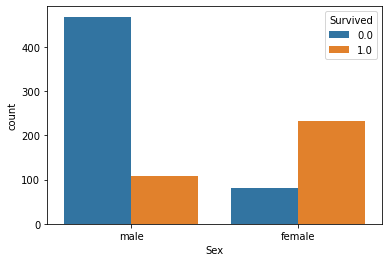

In [6]:
sns.countplot(data['Sex'], hue=data['Survived'])
data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3)
#大部分的男性都罹難了(僅剩18%存活)，而女性則大部分都存活了下來(~75%)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


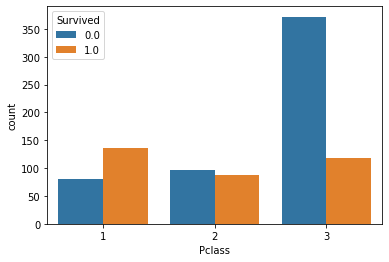

In [7]:
sns.countplot(data['Pclass'], hue=data['Survived'])
data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)
#艙等1存活率最高

,Embarked,Survived
0,C,0.554
1,Q,0.390
2,S,0.337


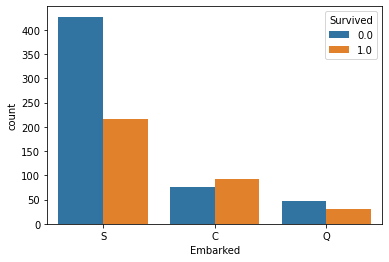

In [8]:
sns.countplot(data['Embarked'], hue=data['Survived'])
data[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().round(3)

#出發港口跟生存率的差異，可以發現S港出發的都比較容易死亡，其原因可能是S城市出發的人買的票價都比較便宜

In [9]:
data[["Embarked", "Fare"]].groupby(['Embarked'], as_index=False).mean().round(3)
#但Q港出發的平均票價是最低的

,Embarked,Fare
0,C,62.336
1,Q,12.409
2,S,27.419


In [10]:
#data['Embarked'].describe()
data[["Embarked", "Fare"]].groupby(['Embarked'], as_index=False).describe()

Fare                                                                      
   count       mean        std     min      25%       50%        75%       max
0  270.0  62.336267  84.185996  4.0125  13.8583  28.51875  78.966675  512.3292
1  123.0  12.409012  13.616133  6.7500   7.7500   7.75000  10.197900   90.0000
2  913.0  27.418824  37.096402  0.0000   8.0500  13.00000  27.750000  263.0000

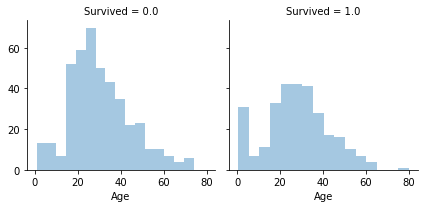

In [11]:
c = sns.FacetGrid(data, col='Survived')
c.map(sns.distplot, 'Age', kde=False)
#年齡跟生存率的關係，可以發現的確年齡小的存活比例高出許多

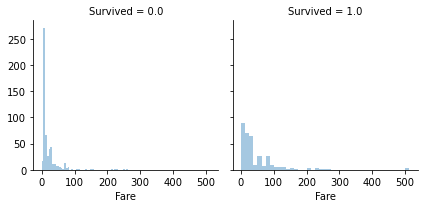

In [12]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Fare', kde=False)
#票價跟生存率的關係，可以發現票價低的乘客死亡率高出許多

<font color=black size=5 face=雅黑>填補缺失值</font>

In [13]:
#填補缺失值，票價只缺一項，用平均值補上，登船港只缺兩項，故用出現頻率最高的S港補上
data['Sex_Code'] = data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
data['Embarked'] = data['Embarked'].fillna('S')

In [14]:
#觀察訓練集的缺值
print(train.isnull().sum(),"\n")
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


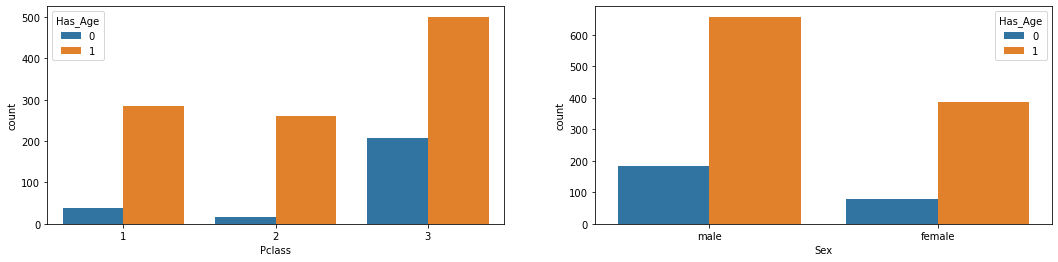

In [15]:
#年齡的缺失值挺高的，所以在處理這個特徵時，先去觀察缺失年齡分布在哪
data['Has_Age'] = data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(data['Pclass'],hue=data['Has_Age'],ax=ax1)
ax2 = sns.countplot(data['Sex'],hue=data['Has_Age'],ax=ax2)
pd.crosstab(data['Has_Age'],data['Sex'],margins=True).round(3)

#可以觀察到男性以及艙等3的年齡缺失值比較多
#所以後續以艙等1、2來做分析最比較不失真

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

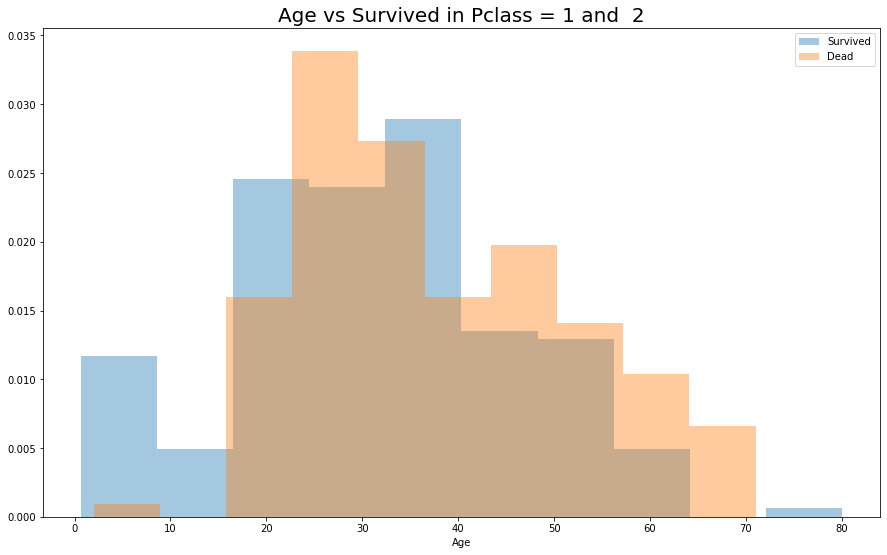

In [16]:
Mask_Has_Age_P12_Survived = ( (data.Has_Age == 1) & (data.Pclass != 3) & (data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (data.Has_Age == 1) & (data.Pclass != 3) & (data.Survived == 0) )

fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

#可以觀察到約莫16.5歲以下，存活率有很大的差距，故可以16為分界，作為一個2元特徵

<font color=black size=5 face=雅黑>特徵工程</font>

In [17]:
data['temp'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data['temp'].unique()　

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [18]:
data.groupby(['temp'])['Age'].mean()
#Master是小孩的稱謂

temp
Capt        70.000000
Col         54.000000
Countess    33.000000
Don         40.000000
Dona        39.000000
Dr          43.571429
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       5.482642
Miss        21.774238
Mlle        24.000000
Mme         24.000000
Mr          32.252151
Mrs         36.994118
Ms          28.000000
Rev         41.250000
Sir         49.000000
Name: Age, dtype: float64

In [19]:
#將少見稱謂歸為一類，並為稱謂分類編號
data['temp'] = data['temp'].replace(['Mlle', 'Ms','Mme'],'Miss')
data['temp'] = data['temp'].replace(['Lady'],'Mrs')
data['temp'] = data['temp'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
data['temp'] = data['temp'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
age_mean = data.groupby('temp')['Age'].mean()
age_mean

temp
0    32.252151
1    45.074074
2     5.482642
3    21.834533
4    37.058480
Name: Age, dtype: float64

In [20]:
#用各稱謂平均年齡填缺失值
age_pred = data.groupby('temp')['Age'].mean().values
age_pred

array([32.25215146, 45.07407407,  5.48264151, 21.83453271, 37.05847953])

In [21]:
data['Age_02'] = data['Age']
for i in range(0,5):
 # 0 1 2 3 4 5
    data.loc[(data.Age.isnull()) & (data.temp == i),'Age_02'] = age_pred[i]
data['Age_02'] = data['Age_02'].astype('int')
data['Age_03'] = ((data['Age_02']) < 17) * 1

In [22]:
print(data.isnull().sum())
#Age_02, Age_03缺失值填補完畢

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
Sex_Code          0
Has_Age           0
temp              0
Age_02            0
Age_03            0
dtype: int64


In [23]:
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data.Age = data.Age.astype(float)

<font color=black size=5 face=雅黑>模型訓練</font>

In [24]:
#分割訓練與測試集
train = data[:len(train)]
test = data[len(train):]

In [25]:
X = train.drop(labels=['Survived','PassengerId'],axis=1)
Y = train['Survived']
X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex_Code', 'Has_Age', 'temp', 'Age_02', 'Age_03'],
      dtype='object')

In [26]:
Base = ['Sex_Code','Pclass','Fare','Age_03']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

#用四個特徵預測存活率，達到0.83502

Base oob score :0.83502
